## Prj06

**The question description**

Approximate the price $e^{-rT}\mathbb E [F(S)]$, where

- Asset follows $S = GBM(S_0, r, \sigma)$;
- Knock-in payoff is given as
$$F(S) = 1000 \cdot I(S_T > K) \cdot I\Big(\min_{1\le k \le m} S(t_k) < H\Big).$$

__Parameters__

- $r = 5\%, \sigma = 15\%, S(0) = 95$
- $T = 0.25, m = 50, H = 85, K = 96.$
- $k = 1000$, $n = 1000$

Repeat $k$ times of the ordinary MC, with $n$ simulation for each MC. Find mean, MSE, and confidence interval using $k$ many MC outputs.

In [1]:
import numpy as np
from scipy.stats import norm
import scipy.stats as ss
import matplotlib.pyplot as plt
from pylab import plt
plt.style.use('seaborn')
%matplotlib inline

In [2]:
# return: ndarray size (m, )
# Let W = bm_1d(T, m)
# W[i] is value at time (i+1)*dt
def bm_1d(T, m):
    dt = T/m
    dW = np.sqrt(dt)*norm.rvs(size = m)
    return dW.cumsum()

# Arethmatic bm
def abm_1d(T, m, b, sigma, x0):
    dt = T/m
    dW = np.sqrt(dt)*norm.rvs(size = m)
    dX = b*dt + sigma*dW
    X = dX.cumsum()
    return x0 + X

# Geometric bm
def gbm_1d(T, m, b, sigma, x0):
    L = abm_1d(T, m, b - 0.5*sigma**2, sigma, 0) #normalized log process
    return x0*np.exp(L)

In [3]:
# enter all parameters we know
r = .05; sigma = 0.15; s0 = 95
T = 0.25; H = 85; K = 96
k = 1000; n = 1000; m = 50
dt = T/m

In [4]:
val = np.zeros(k)
payoff = np.zeros(n)
for i in np.arange(k):
    for j in np.arange(n):
        S = gbm_1d(T, m, r, sigma, s0)
        payoff[j] = 1000*float(S[-1]>K)*float(S.min()<H)
    val[i] = payoff.mean()*np.exp(-r*T)

print('Mean is ' + str(val.mean()))    
print('MSE is ' + str(val.var()))

sample_mean = val.mean()
sample_variance = val.var()

Mean is 0.5816833244908962
MSE is 0.6028185751165599


In [5]:
# the confidence level:
a = 0.05
Int_l = sample_mean - sample_variance/ np.sqrt(k) * ss.norm.cdf(a/2)
Int_r = sample_mean + sample_variance/ np.sqrt(k) * ss.norm.cdf(a/2)
print(f"The confidence interval of payoff with confidence level equal to 95% is:\n [{Int_l}, {Int_r}]")

The confidence interval of payoff with confidence level equal to 95% is:
 [0.5719618218335145, 0.5914048271482779]


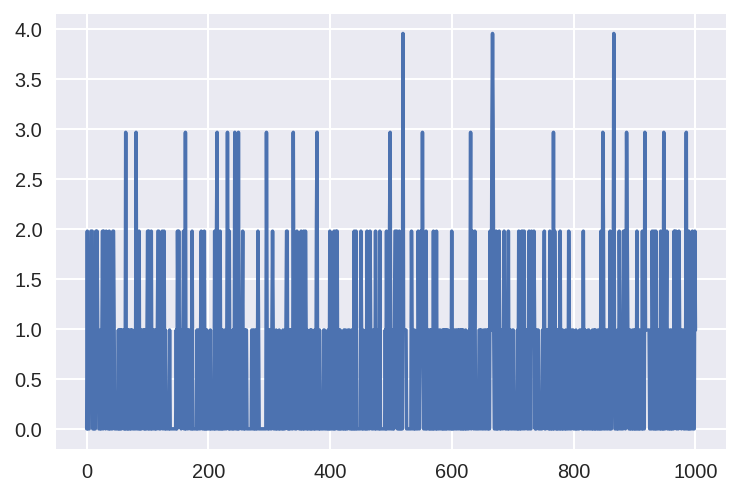

In [6]:
# the plot of the value of the call option in each simulation
plt.plot(np.linspace(0, k, k), val)

Repeat the above procedure with importance sampling.



We denote $K = S_0 e^{c}$ and $H = S_0 e^{-b}$, the knock-in call option's payoff is given as

$$
\begin{align*}
 F(S) &=& 1000 \cdot I(S_T > S_0 e^{c}) \cdot I\Big(\min_{1\le k \le m} S(t_k) < S_0 e^{-b} \Big)  \\
       &=& 1000 \cdot I(L_T > c) \cdot I\Big(\min_{1\le k \le m} L(t_k) < -b \Big) \\
       &=& 1000 \cdot I(L_T > c) \cdot I(\tau \leq T),
\end{align*} \tag{1}
$$
where $\tau = inf \{i : L(t_i) < -b \}.$

We set that

$$L_t = (r-\frac{1}{2} \sigma^2) t + \sigma W_t = \int_{0}^{t} (\hat{r_s} - 0.5 \sigma^2) ds + \sigma \hat{W_t},$$

so we have 

$$W_t = \int_{0}^{t} \frac{\hat{r_s} - s}{\sigma} d s + \hat{W_t} =\int_{0}^{t} \theta_s d s + \hat{W_t}  .$$

By the Girsanov theorem, we can get the Radon-Nikodym derivative as follow:

$$
\begin{equation*}
\frac{d \mathbb{P}}{d \mathbb{\hat{P}}} = \gamma(\hat{W}) = exp \Big \{ \int_{0}^{T} \theta_s d \hat{W_s} - \frac{1}{2} \int_{0}^{T} \theta_{s}^{2} ds \Big \}.
\end{equation*}
$$

And then we can get the price of the knock-in option by the formula

$$e^{-rT} \hat{\mathbb{E}} \{ 1000 \cdot I(L_T > c) \cdot I(\tau \leq T) \gamma(\hat{W}) \}, $$

where $L_t = \int_{0}^{t} (\hat{r_s} - 0.5 \sigma^2) ds + \sigma \hat{W_t}$ and $\tau = inf \{i : L(t_i) < -b \} \tag{2}$

To get the exact form of the above formulas and to make the simulation easier to implement, we can take

$$
\hat{r_s} = 
\begin{cases}
  -r_1, & s < h \\
  r_2, & s \geq h
\end{cases}
$$

then we have the form of $L_t$ as follow:

$$
L_t = 
\begin{cases}
  (-r_1 - \frac{1}{2} \sigma^2) t + \sigma \hat{W_t}, & t < h \\
  r_2(t -h) - r_1 h - \frac{1}{2} \sigma^2 t + \sigma \hat{W_t}, & t \geq h
\end{cases}\tag{3}
$$

And since 

$$
\theta_s = 
\begin{cases}
  \theta_1 = \frac{-r_1 - r}{\sigma}, & s < h \\
  \theta_2 = \frac{r_2 - r}{\sigma}, & s \geq h
\end{cases}
$$

we can get the exact form of the $\gamma(\hat{W})$ by the formula

$$\gamma(\hat{W}) = exp \Big \{ \theta_1 \hat{W_h} + \theta_2 (\hat{W_T} - \hat{W_h}) - \frac{1}{2} \theta_1^2 h - \frac{1}{2} \theta_2^2 (T-h) \Big \} \tag{4}$$


In [7]:
b = - np.log(H/s0)
c = np.log(K/s0)
print(f" The parameter b is equal to {b}")
print(f" The parameter c is equal to {c}")

 The parameter b is equal to 0.11122563511022437
 The parameter c is equal to 0.010471299867295437


In [8]:
r_1 = 0.06
r_2 = 0.06
theta_1 = - (r_1 + r)/sigma
theta_2 =  (r_2 - r) /sigma

h = int(m/2)

In [9]:
# importance sampling of MC simulation about the knoch-in call option with barrier H
r = .05; sigma = 0.15; s0 = 95
T = 0.25; H = 85; K = 96
k = 1000; n = 1000; m = 50
dt = T/m
val = np.zeros(k)
payoff = np.zeros(n)
for i in np.arange(k):
    for j in np.arange(n):
        dW = np.sqrt(dt)*norm.rvs(size = m)
        W_t = dW.cumsum()      # Brownian Motion
        dL1_t = (- r_1 - 0.5 * sigma**2) *dt + sigma * dW[0:h]   # the scatter of Lt in first stage
        dL2_t = (r_2 - 0.5 *sigma**2)*dt + sigma* dW[h:(m+1)]       # the scatter of Lt in second stage
        L = np.append(dL1_t , dL2_t).cumsum()     # the path of Lt
        gamma1 = theta_1 * dL1_t.cumsum()[-1] + theta_2 * dL2_t.cumsum()[-1] - (theta_1**2 + theta_2**2)/T/4
        gamma = np.exp(gamma1)
        payoff[j] = 1000*float(L[-1]>c)*float(L.min()<-b) * gamma 
    val[i] = payoff.mean()*np.exp(-r*T)
    
print('MC computation for down_in_digital_call value: \n')
print('Mean is ' + str(val.mean()))    
print('MSE is ' + str(val.var()))

sample_mean = val.mean()
sample_variance = val.var()

MC computation for down_in_digital_call value: 

Mean is 0.5826525352170749
MSE is 0.3477708603902901


In [10]:
# the confidence level:
a = 0.05
Int_l = sample_mean - sample_variance/ np.sqrt(k) * ss.norm.cdf(a/2)
Int_r = sample_mean + sample_variance/ np.sqrt(k) * ss.norm.cdf(a/2)
print(f"The confidence interval of payoff with confidence level equal to 95% is:\n [{Int_l}, {Int_r}]")

The confidence interval of payoff with confidence level equal to 95% is:
 [0.5770441225320637, 0.5882609479020862]


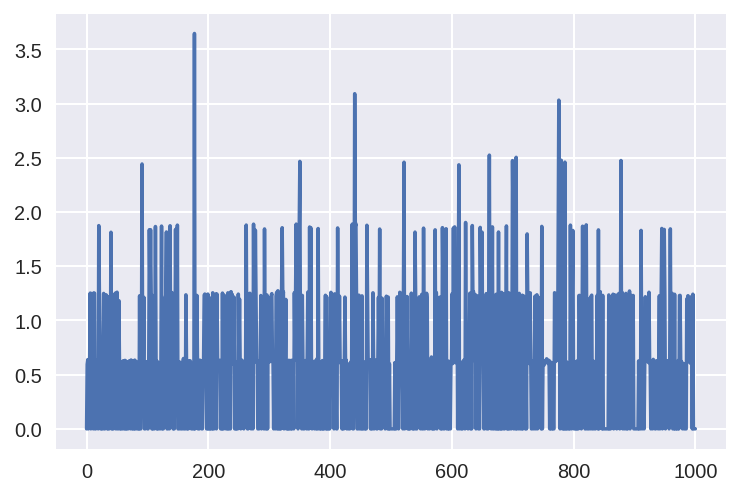

In [11]:
plt.plot(np.linspace(0, k, k), val)

Explain your decision of new probability in your importance sampling. Is it optimal choice?

As we see, by the Girsanov theorem, we can get the Radon-Nikodym derivative as follow:

$$
\begin{align*}
\frac{d \mathbb{P}}{d \mathbb{\hat{P}}} = \gamma(\hat{W}) = exp \Bigg \{ \int_{0}^{T} \theta_s d \hat{W_s} - \frac{1}{2} \int_{0}^{T} \theta_{s}^{2} ds \Bigg \}.
\end{align*}
$$

We get the price of the knock-in option by:

$$e^{-rT} \hat{\mathbb{E}} \{ 1000 \cdot I(L_T > c) \cdot I(\tau \leq T) \gamma(\hat{W}) \}, $$

where $L_t = \int_{0}^{t} (\hat{r_s} - 0.5 \sigma^2) ds + \sigma \hat{W_t}$ and $\tau = inf \{i : L(t_i) < -b \}.$

We set  $h = T/2$ and 

$$
\hat{r_s} = 
\begin{cases}
  -r_1, & s < h \\
  r_2, & s \geq h
\end{cases}
$$


In [12]:
# change the r_1 and r_2 and observe the change of MSE of the MC simulation 

r_list = np.linspace(0.03, 0.07, 5)

# importance sampling of MC simulation about the knoch-in call option with barrier H
l = 5
val = np.zeros(k)
payoff = np.zeros(n)
sample_variance = np.zeros(l)
sample_mean = np.zeros(l)

for s in np.arange(l):
    for i in np.arange(k):
        for j in np.arange(n):
            dW = np.sqrt(dt)*norm.rvs(size = m)
            W_t = dW.cumsum()      ## the path of Brownian Motion
            dL1_t = (- r_list[s] - 0.5 * sigma**2) *dt + sigma * dW[0:h]   ## the scatter of Lt in the first stage
            dL2_t = (r_list[s] - 0.5 *sigma**2)*dt + sigma* dW[h:(m+1)]       ## the scatter of Lt in the second stage
            L = np.append(dL1_t , dL2_t).cumsum()     ## the path of Lt
            theta_1 = - (r_list[s] + r)/sigma
            theta_2 =  (r_list[s] - r) /sigma
            gamma1 = theta_1 * dL1_t.cumsum()[-1] + theta_2 * dL2_t.cumsum()[-1] - (theta_1**2 + theta_2**2)/T/4
            gamma = np.exp(gamma1)
            payoff[j] = 1000*float(L[-1]>c)*float(L.min()<-b) * gamma 
        val[i] = payoff.mean()*np.exp(-r*T)
    sample_mean[s] = val.mean()
    sample_variance[s] = val.var()

print(sample_mean)
print(sample_variance)

[0.5137079  0.5513912  0.53505874 0.57846341 0.53341425]
[0.38690628 0.36516959 0.34874789 0.37679004 0.32262071]
